<a href="https://colab.research.google.com/github/ritesh2448/Text-Detection-And-Recognition/blob/master/Text%20Recognition%20module/Text_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 31 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (26.8 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../tesseract

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=026510340b50c076d6652cf76065962271b0cbd841e76132fc22f214cdc81195
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [ ]:
!which tesseract

/usr/bin/tesseract


In [ ]:
def preprocess(file_path):
	X = []
	img = cv2.imread(file_path)
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

	#Removing noise
	#img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
		
	#x_s = img_size/img.shape[1]
	#y_s = img_size/img.shape[0]

	resized_img = cv2.resize(img,(512,512))
	X.append(resized_img)
	X = np.asarray(X)
	return X

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

In [ ]:
def yolo_loss(y_true,y_pred):
   no_obj = (1 - y_true[:,:,:,0])*0.5
   coords = y_true[:,:,:,0]*5
   c_loss = K.sum(K.square(y_true[:,:,:,0]-y_pred[:,:,:,0])*no_obj)
   c_loss1 =  K.sum(K.square(y_true[:,:,:,0]-y_pred[:,:,:,0])*coords)
   w_loss = K.sum(K.square(K.sqrt(y_true[:,:,:,3])-K.sqrt(y_pred[:,:,:,3]))*coords)
   h_loss = K.sum(K.square(K.sqrt(y_true[:,:,:,4])-K.sqrt(y_pred[:,:,:,4]))*coords)
   x_loss = K.sum(K.square(y_true[:,:,:,1]-y_pred[:,:,:,1])*coords)
   y_loss = K.sum(K.square(y_true[:,:,:,2]-y_pred[:,:,:,2])*coords)
   loss = c_loss + c_loss1 + w_loss + h_loss + x_loss + y_loss
   return loss

In [ ]:
model = keras.models.load_model('/content/gdrive/MyDrive/mini_project/yolo_model3.h5',custom_objects={'yolo_loss': yolo_loss})

In [ ]:
import cv2
import pytesseract
#from PIL import Image

pytesseract.pytesseract.tesseract_cmd=r'/usr/bin/tesseract'


def text_extract(image,x1,y1,x2,y2):
    #image =cv2.imread(img)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    gray  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)

    thresh=255-cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

    ROI =thresh[y1:y2,x1:x2]
    #plt.imshow(ROI,cmap='gray')
    #plt.show()
    custom_config = ("-l eng --oem 1 --psm 6")
    data = pytesseract.image_to_string(ROI, lang='eng',config=custom_config)
    return data

In [ ]:
def gen_bounding_boxes(X,Y):
  grid_size = 16
  img_size = 512
  per_grid_pix = img_size//grid_size
  idx = 0
  img = X[idx].copy()
  bounding_boxes = []
  scores =[]

  for i in range(Y.shape[1]):
      for j in range(Y.shape[2]):
          if Y[idx][i][j][0]>=0.4:
              x1 = Y[idx][i][j][1]*per_grid_pix + j*per_grid_pix - (Y[idx][i][j][3]*img_size)/2
              x2 = Y[idx][i][j][1]*per_grid_pix + j*per_grid_pix + (Y[idx][i][j][3]*img_size)/2
              y1 = Y[idx][i][j][2]*per_grid_pix + i*per_grid_pix - (Y[idx][i][j][4]*img_size)/2
              y2 = Y[idx][i][j][2]*per_grid_pix + i*per_grid_pix + (Y[idx][i][j][4]*img_size)/2
              bounding_boxes.append([int(y1),int(x1),int(y2),int(x2)])
              scores.append(Y[idx][i][j][0])
  
  t_bounding_boxes = []
  if len(bounding_boxes)!=0:
    t_bounding_boxes = nn(bounding_boxes,scores)
    t_bounding_boxes = sorted(t_bounding_boxes , key=lambda k: [k[0]+k[2], k[1]+k[3]])
    
    

  for idx,i in enumerate(t_bounding_boxes):
    if i[1]==i[3] or i[0]==i[2]:
      continue
    print("{} - {}".format(idx,text_extract(img, i[1], i[0], i[3], i[2])))

  for idx,i in enumerate(t_bounding_boxes):
    cv2.rectangle(img,(int(i[1]),int(i[0])),(int(i[3]),int(i[2])),(0,0,255),2)
    cv2.putText(img, str(idx), (i[1], i[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
  plt.imshow(img)
  plt.show() 

'''
def iou(b1,b2):
  inter_x1 = max(b1[1],b2[1])
  inter_y1 = max(b1[0],b2[0])
  inter_x2 = min(b1[3],b2[3])
  inter_y2 = min(b1[2],b2[2])

  inter_width = (inter_x2 - inter_x1) if (inter_x2 - inter_x1)>0 else 0
  inter_height = (inter_y2 - inter_y1) if (inter_y2 - inter_y1)>0 else 0
  inter_area = inter_width*inter_height

  b1_area = abs((b1[0] - b1[2])*(b1[1] - b1[3]))
  b2_area = abs((b2[0] - b2[2])*(b2[1] - b2[3]))
  return inter_area/(min(b1_area,b2_area))
'''

def nn(bounding_boxes,scores):
  #scores = [] 
  #for b in bounding_boxes:
  #  scores.append(abs((b[0] - b[2])*(b[1] - b[3])))
  indices = tf.image.non_max_suppression(bounding_boxes, scores,300,iou_threshold=0.2)
  true_bounding_boxes = []
  for i in indices:
    true_bounding_boxes.append(bounding_boxes[i])
  return true_bounding_boxes

0 - Fira ¢

1 - door

2 - | keep

3 - ) locke



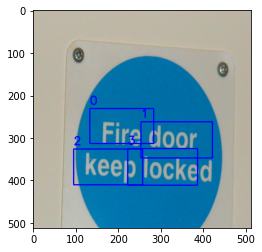

In [ ]:
X=preprocess("/content/gdrive/MyDrive/mini_project/images/img_89.jpg")
gen_bounding_boxes(X,model.predict(X))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 1024)      2098176   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 1024)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 1024)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 1024)      4096      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)       262400    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 256)      